# ARIMA

In [14]:
import pandas as pd
import ssl
import urllib.request
import io

context = ssl._create_unverified_context()
response = urllib.request.urlopen('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/refs/heads/main/data/US_macro_Quarterly.csv', context=context)
csv_data = response.read().decode('utf-8')
df = pd.read_csv(io.StringIO(csv_data))
df.head()

,Unnamed: 0,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959-03-31,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959-06-30,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959-09-30,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959-12-31,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960-03-31,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [15]:
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index(pd.PeriodIndex(df['Unnamed: 0'], freq='Q'), inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [16]:
# keep 'cpi' drop the other columns
df = df[['cpi']]

<Axes: xlabel='Unnamed: 0'>

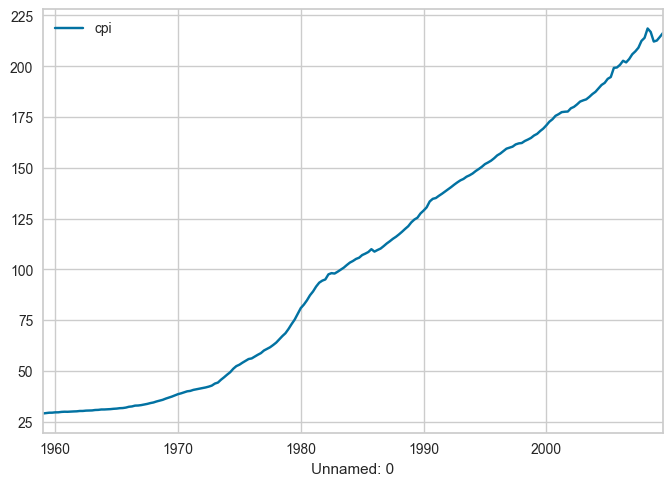

In [17]:
#  plot the data
df.plot()

The data is no stationary due to the upward trend. We would need to do differencing in this instance.

In [18]:
from pycaret.time_series import *

In [19]:
exp = TSForecastingExperiment()
exp.setup(data=df, fh=24)

,Description,Value
0,session_id,1480
1,Target,cpi
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(203, 1)"
5,Transformed data shape,"(203, 1)"
6,Transformed train set shape,"(179, 1)"
7,Transformed test set shape,"(24, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


We have 179 insample observations and 24 out of sample observations

In [20]:
exp.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,203.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,105.075788
3,Summary,Statistics,Transformed,Median,,104.1
4,Summary,Statistics,Transformed,Standard Deviation,,61.278878
5,Summary,Statistics,Transformed,Variance,,3755.100856
6,Summary,Statistics,Transformed,Kurtosis,,-1.344882
7,Summary,Statistics,Transformed,Skewness,,0.223577
8,Summary,Statistics,Transformed,# Distinct Values,,203.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",3684.722748


In [21]:
exp.plot_model(plot="diff", data_kwargs={"order_list": [1,2], "acf": True, "pacf": True})

In [22]:
exp.plot_model(plot="diff", data_kwargs={"lags_list": [[1, 4]], "acf": True, "pacf": True})

Looking at the first ACF plot there appears to be a slight seasonality component that is being captured in the 2nd differencing and the there is sharp drop off after the first lag. Looking at the PACF plot there is a significant drop after the first lag. When looking at differenced data with seasonality there are significant spikes at lags 4. Therefore the model I would use is

sarima(1,1,1)(1,1,1,4)

In [23]:
# arima(1,1,1)
ar1 = exp.create_model('arima', order = (1,1,1), seasonal_order=(0,0,0,4), with_intercept=True, cross_validation=False)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.7906,2.7050,7.3620,8.5105,0.0353,0.0361,0.2681


We wouldn't be interested in doing the ARMA model because the data is not stationary so we need the integrated part by differencing the data.

In [24]:
# sarima(1,1,1)(0,1,0,4)
sar1 = exp.create_model('arima', order = (1,1,1), seasonal_order=(0,1,0,4), with_intercept=True, cross_validation=False)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.4441,2.3809,6.4481,7.4908,0.0309,0.0316,0.4329


In [25]:
rwwd= exp.create_model('arima', order = (0,1,0), seasonal_order=(0,0,0,12) , with_intercept= True, cross_validation=False)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.8597,2.7581,7.5445,8.6773,0.0362,0.0371,0.2391


It woulnd't be worth our time trying random walk with no drift as there is a clear upward trend in the data.

In [26]:
my_models = [ar1, sar1, rwwd]
exp.compare_models(my_models, cross_validation=False, sort='r2')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
1,ARIMA,2.4441,2.3809,6.4481,7.4908,0.0309,0.0316,0.4329,0.0300
0,ARIMA,2.7906,2.7050,7.3620,8.5105,0.0353,0.0361,0.2681,0.0500
2,ARIMA,2.8597,2.7581,7.5445,8.6773,0.0362,0.0371,0.2391,0.0100


ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 0, 4))

Our sarima model had the highest R2 

y t′′ = 2.5+0.6yt−1′′− 0.3ϵt−1 + ϵt

In [27]:
exp.plot_model(my_models, plot='insample')

In [28]:
exp.plot_model(my_models, plot='forecast', data_kwargs={"fh": 36})

In [29]:
exp.plot_model(ar1, plot='diagnostics')

The residuals appear to be stationary

In [30]:
exp.check_stats(ar1, test = 'adf')

,Test,Test Name,Data,Property,Setting,Value
0,Stationarity,ADF,Residual,Stationarity,{'alpha': 0.05},True
1,Stationarity,ADF,Residual,p-value,{'alpha': 0.05},0.0
2,Stationarity,ADF,Residual,Test Statistic,{'alpha': 0.05},-6.338772
3,Stationarity,ADF,Residual,Critical Value 1%,{'alpha': 0.05},-3.46828
4,Stationarity,ADF,Residual,Critical Value 5%,{'alpha': 0.05},-2.878202
5,Stationarity,ADF,Residual,Critical Value 10%,{'alpha': 0.05},-2.575653


The p-value is 0 meaning the residuals are stationary

# Auto ARIMA and Auto ETS

In [31]:
auto_arima = exp.create_model('auto_arima', cross_validation=False)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.6993,2.5990,7.1211,8.1768,0.0342,0.0350,0.3243


In [32]:
auto_ets = exp.create_model('ets', cross_validation=False)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.8143,2.7095,7.4247,8.5244,0.0356,0.0365,0.2657


In [33]:
comparison_models = [auto_arima, auto_ets, ar1]
exp.compare_models(comparison_models, cross_validation=False, sort='r2')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
0,Auto ARIMA,2.6993,2.5990,7.1211,8.1768,0.0342,0.0350,0.3243,3.1000
2,ARIMA,2.7906,2.7050,7.3620,8.5105,0.0353,0.0361,0.2681,0.0400
1,ETS,2.8143,2.7095,7.4247,8.5244,0.0356,0.0365,0.2657,0.0800


AutoARIMA(random_state=1480, sp=3, suppress_warnings=True)

In [34]:
exp.plot_model(comparison_models, plot='forecast', data_kwargs={"fh": 36})

In [35]:
my_best_model = exp.finalize_model(auto_arima)

In [36]:
unseen_predictions = exp.predict_model(my_best_model, fh=62, return_pred_int= True)
unseen_predictions.tail()

,y_pred,lower,upper
2024Q1,270.0307,216.9340,323.1274
2024Q2,270.9676,216.6557,325.2794
2024Q3,271.9044,216.3684,327.4404
2024Q4,272.8413,216.0722,329.6104
2025Q1,273.7781,215.7670,331.7892


The prediction is 273.87